In [1]:
#Import Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#Load the data
df = pd.read_csv("datanew.csv")
df = df.drop(columns=['Unnamed: 0'])

In [5]:
#Family Occupation is telling us a lot of the same things as Family Qualification. Remove Occupation
df = df.drop(columns=["Mother's occupation", "Father's occupation"])

In [6]:
#0 & 1 values for already binary columns
df["Displaced"] = df["Displaced"].map({'yes': 1, 'no': 0})
df["Educational special needs"] = df["Educational special needs"].map({'yes': 1, 'no': 0})
df["Debtor"] = df["Debtor"].map({'yes': 1, 'no': 0})
df["Tuition fees up to date"] = df["Tuition fees up to date"].map({'yes': 1, 'no': 0})
df["Gender"] = df["Gender"].map({'female': 1, 'male': 0})
df["Scholarship holder"] = df["Scholarship holder"].map({'yes': 1, 'no': 0})
df["International"] = df["International"].map({'yes': 1, 'no': 0})

In [7]:
#Create Dummy Features
#Identify Object Columns to Binarize
object_columns = df.select_dtypes(object)
obj = object_columns.columns
#Numerical Columns to merge with the Binarized Columns
num_columns = df.select_dtypes([float, int])
num = num_columns.columns

In [8]:
#Binarize Variables
bdf = pd.get_dummies(df[obj], dtype='int')
#This makes two target variables, we just need to look at Target_Graduate to see 1 for Graduate, 0 for Dropout 
bdf = bdf.drop('Target_Dropout', axis=1)
ndf = df[num]

In [9]:
#Re-Merge Binary Portion of DataFrame and Numerical Portion of DataFrame
df2 = pd.concat([bdf, ndf], axis=1)
df_prediction = df2[df2["Target_Enrolled"]==1]
df2 = df2[df2["Target_Enrolled"]==0]
df2['Target_Graduate'] = df2['Target_Graduate'].map({1: "Graduate", 0: "Dropout"})

In [10]:
#Train, Test, Split
X = df2.drop(columns=["Target_Graduate", "Target_Enrolled"], axis = 1)
y = df2['Target_Graduate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=44)

In [11]:
#Apply StandardScaler to Numerical Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
#Logistic Regression Fit
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

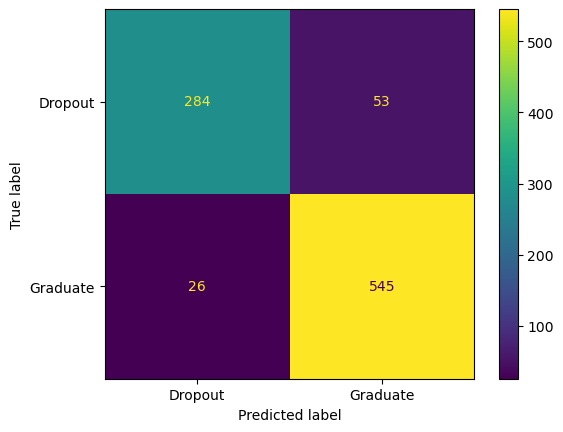

In [13]:
#Logistic Regression Confusion Matrix
cm = confusion_matrix(y_test,y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [14]:
#Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Dropout       0.92      0.84      0.88       337
    Graduate       0.91      0.95      0.93       571

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.91       908
weighted avg       0.91      0.91      0.91       908



In [15]:
#KFold Analyis Logistic Regression
kf = KFold(n_splits = 5, shuffle=True, random_state=44)
cv_results = cross_val_score(logreg, X_train_scaled, y_train, cv=kf)
print(np.mean(cv_results), np.std(cv_results))

0.9136656772800864 0.013648809518728648


In [16]:
#Random Forest Hyperparamter Tuning
rf = RandomForestClassifier(random_state=44)
n_estimators=[int(x) for x in np.linspace(start = 200, stop = 2000, num=10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter=100, cv =3, random_state = 44)
rf_random.fit(X_train_scaled, y_train)
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80}

In [17]:
#Random Forest Model
rfmodel = RandomForestClassifier(n_estimators=1400, max_features='sqrt', max_depth=80, min_samples_split=5, min_samples_leaf=1, n_jobs=-1)
rfmodel.fit(X_train_scaled, y_train)
y_pred_rf = rfmodel.predict(X_test_scaled)

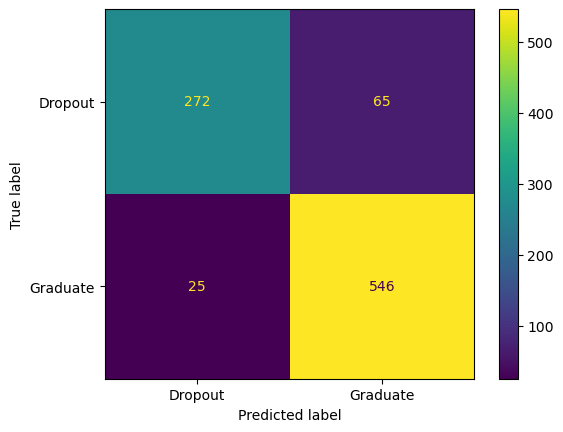

In [18]:
#Random Forest Confusion Matrix
cm = confusion_matrix(y_test,y_pred_rf, labels=rfmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfmodel.classes_)
disp.plot()
plt.show()

In [19]:
#Random Forest Scores
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

     Dropout       0.92      0.81      0.86       337
    Graduate       0.89      0.96      0.92       571

    accuracy                           0.90       908
   macro avg       0.90      0.88      0.89       908
weighted avg       0.90      0.90      0.90       908



In [20]:
#KFold Random Forest
kf = KFold(n_splits = 5, shuffle=True, random_state=44)
cv_results = cross_val_score(rfmodel, X_train_scaled, y_train, cv=kf)
print(np.mean(cv_results), np.std(cv_results))

0.9077866972477064 0.016454974500498983


In [21]:
#KNN Hyperparameter Tuning
train_accuracies = []
test_accuracies = []
neighbors = np.arange(1,26)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    train_accuracies.append(knn.score(X_train_scaled, y_train))
    test_accuracies.append(knn.score(X_test_scaled, y_test))

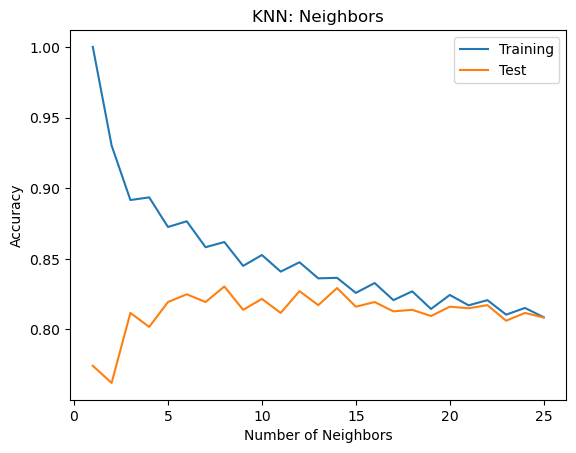

In [22]:
#Plot Nearest Neighbors
plt.plot(neighbors, train_accuracies, label="Training")
plt.plot(neighbors, test_accuracies, label="Test")
plt.legend()
plt.title("KNN: Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [23]:
#KNN Model
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

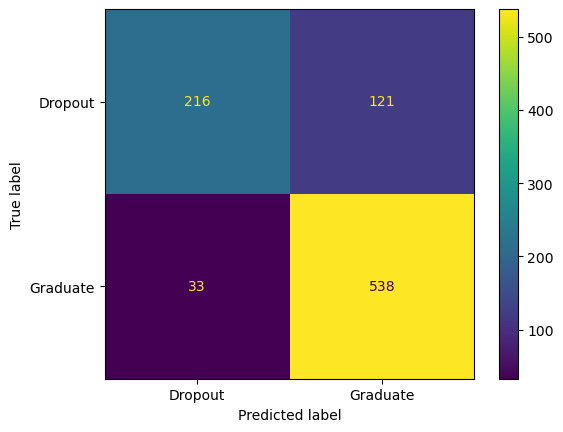

In [24]:
#KNN Confusion Matrix
cm = confusion_matrix(y_test,y_pred_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

In [25]:
#KNN Scores
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     Dropout       0.87      0.64      0.74       337
    Graduate       0.82      0.94      0.87       571

    accuracy                           0.83       908
   macro avg       0.84      0.79      0.81       908
weighted avg       0.84      0.83      0.82       908



In [26]:
#KFold KNN
kf = KFold(n_splits = 5, shuffle=True, random_state=44)
cv_results = cross_val_score(knn, X_train_scaled, y_train, cv=kf)
print(np.mean(cv_results), np.std(cv_results))

0.8199784133837023 0.01777389670805794


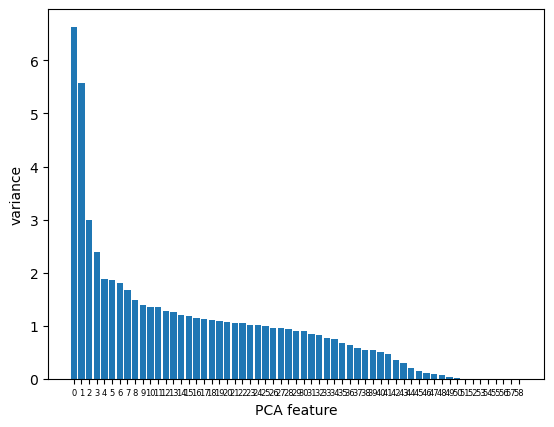

In [27]:
#PCA Model Fit
pca = PCA()
pca.fit_transform(X_train_scaled)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, fontsize=6)
plt.show()

In [28]:
#PCA Model Fit
pca = PCA(n_components=4)
dt = DecisionTreeClassifier()
X_transformed = pca.fit_transform(X_train_scaled)
dt.fit(X_transformed, y_train)
X_test_transformed = pca.transform(X_test_scaled)
y_pred_pca = dt.predict(X_test_transformed)

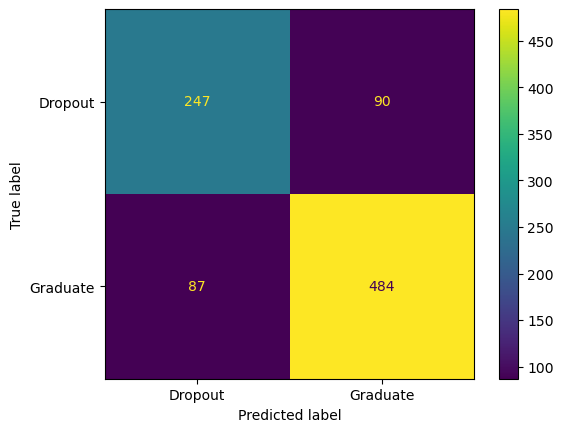

In [29]:
#PCA Confusion Matrix
cm = confusion_matrix(y_test,y_pred_pca, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

In [30]:
#PCA Scores
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

     Dropout       0.74      0.73      0.74       337
    Graduate       0.84      0.85      0.85       571

    accuracy                           0.81       908
   macro avg       0.79      0.79      0.79       908
weighted avg       0.80      0.81      0.80       908



In [31]:
#KFold PCA
kf = KFold(n_splits = 5, shuffle=True, random_state=44)
cv_results = cross_val_score(dt, X_train_scaled, y_train, cv=kf)
print(np.mean(cv_results), np.std(cv_results))

0.856354560172693 0.019747141428092706


In [32]:
#PCA w/ Random Forest
pca = PCA(n_components=4)
rf2 = RandomForestClassifier()
rf2.fit(X_transformed, y_train)
y_pred_pca2 = rf2.predict(X_test_transformed)

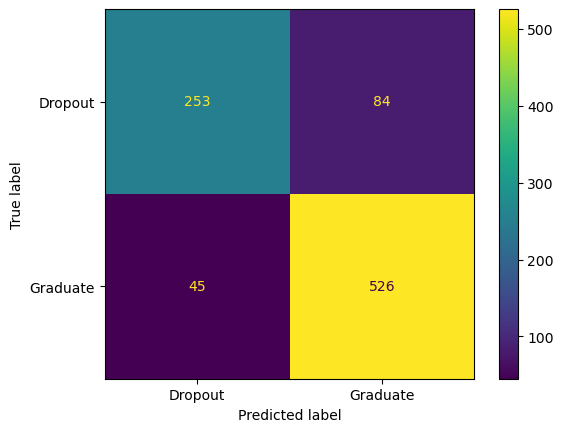

In [33]:
#PCA w/ Random Forest Confusion Matrix
cm = confusion_matrix(y_test,y_pred_pca2, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

In [34]:
#PCA Scores w/ Random Forest
print(classification_report(y_test, y_pred_pca2))

              precision    recall  f1-score   support

     Dropout       0.85      0.75      0.80       337
    Graduate       0.86      0.92      0.89       571

    accuracy                           0.86       908
   macro avg       0.86      0.84      0.84       908
weighted avg       0.86      0.86      0.86       908



In [35]:
#SVM Fit
clf = svm.SVC()
clf.fit(X_train_scaled, y_train)
y_pred_svm = clf.predict(X_test_scaled)

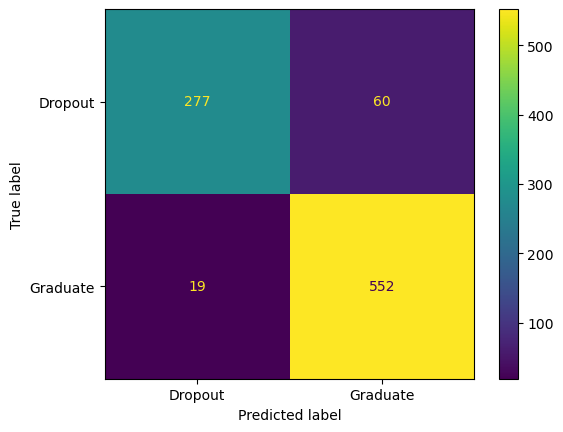

In [36]:
#SVM Confusion Matrix
cm = confusion_matrix(y_test,y_pred_svm, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [37]:
#SVM Scores
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

     Dropout       0.94      0.82      0.88       337
    Graduate       0.90      0.97      0.93       571

    accuracy                           0.91       908
   macro avg       0.92      0.89      0.90       908
weighted avg       0.91      0.91      0.91       908



In [38]:
#KFold SVM
kf = KFold(n_splits = 5, shuffle=True, random_state=44)
cv_results = cross_val_score(clf, X_train_scaled, y_train, cv=kf)
print(np.mean(cv_results), np.std(cv_results))

0.9030099838100376 0.008903625120528785


In [39]:
#Classification Report Log_Reg
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Dropout       0.92      0.84      0.88       337
    Graduate       0.91      0.95      0.93       571

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.91       908
weighted avg       0.91      0.91      0.91       908



In [40]:
#Random Forest Scores
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

     Dropout       0.92      0.81      0.86       337
    Graduate       0.89      0.96      0.92       571

    accuracy                           0.90       908
   macro avg       0.90      0.88      0.89       908
weighted avg       0.90      0.90      0.90       908



In [41]:
#Choose a Model
#Given that our goal is to reduce dropouts, we want to pick the model that performs best at identifying potential dropouts. 
#KNN and PCA with Decision Tree both performed significiantly in the recall metric for Dropouts, so I'll eliminate those. 
#Logistic Regression, Random Forest & SVM performed the best on our data set. 
#SVM is far and away the best at predicting graduates, but does not do as well at dropouts. 
#Logistic Regression has stronger recall on Dropouts, meaning that it is best at predicting dropouts correctly. 
#Logistic Regression will be the model that we take to the Academic Staff. 

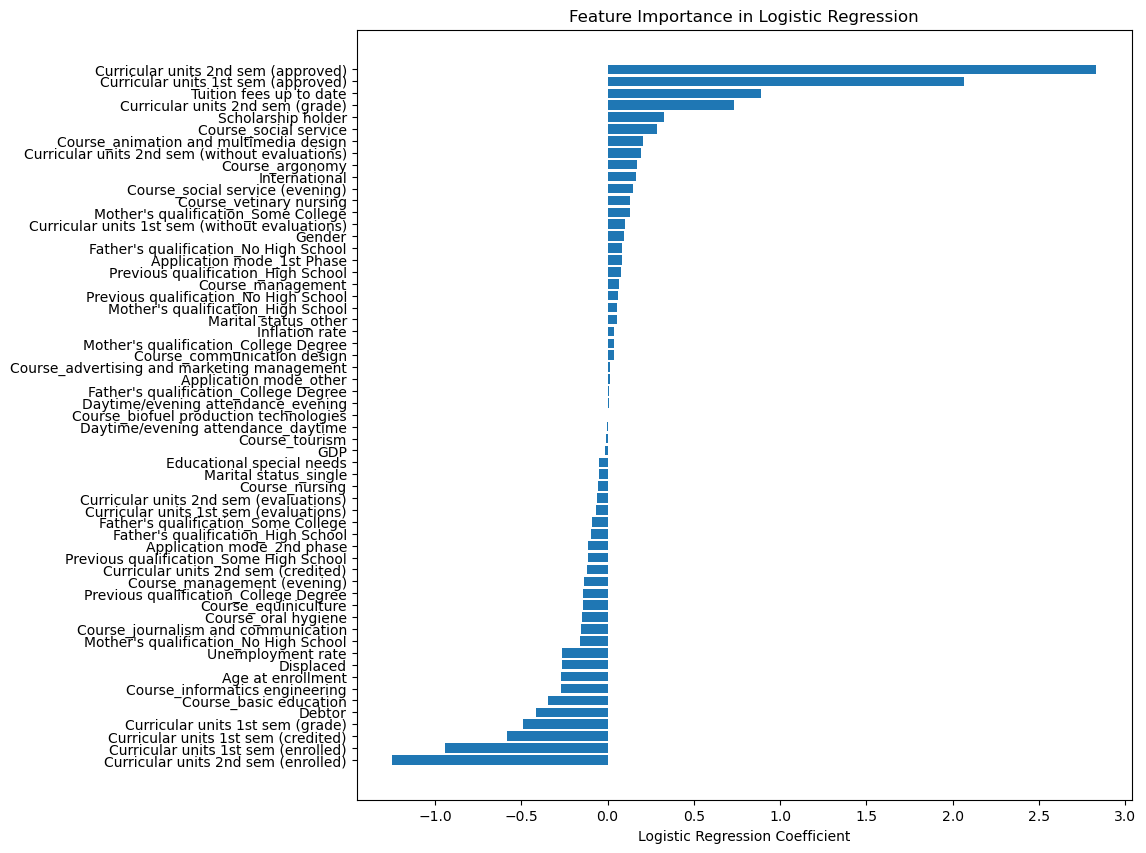

In [42]:
#Most Important Features of Model
features = X.columns
most_important = pd.DataFrame(features)
coef = logreg.coef_
coef = pd.DataFrame(coef)
coef = coef.T
most_important['coef'] = coef
most_important = most_important.sort_values(by='coef', ascending=True)


plt.figure(figsize=(10,10))
plt.barh(most_important[0], most_important['coef'], align='center')
plt.xlabel('Logistic Regression Coefficient')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [43]:
#Use df_prediction to make features, scale, run prediction
X_predict = df_prediction.drop(columns=["Target_Graduate", "Target_Enrolled"], axis = 1)
X_predict_scaled = scaler.transform(X_predict)
y_enrolled = logreg.predict(X_predict_scaled)

In [44]:
#Append to DataFrame, create csv with the projections for currently enrolled students. 
df_prediction["Grad Projection"] = y_enrolled
grad_projection = df_prediction["Grad Projection"]
grad_projection.to_csv('projections.csv', index=False)

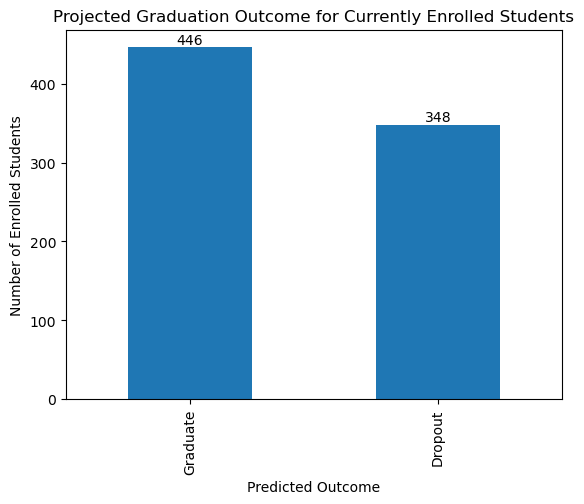

In [45]:
#Visualize the Dropout vs. Graduation Prediction as Bar Chart
_ = df_prediction["Grad Projection"].value_counts().plot(kind="bar")
_.bar_label(_.containers[0], label_type="edge")
plt.xlabel("Predicted Outcome")
plt.ylabel("Number of Enrolled Students")
plt.title("Projected Graduation Outcome for Currently Enrolled Students")
plt.show()